# Anomaly Detection 


In [1]:
# 경고 메시지 출력 끄기
import warnings 
warnings.filterwarnings(action='ignore')

# 노트북 셀 표시를 브라우저 전체 폭 사용하기
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import clear_output

%matplotlib inline
import matplotlib.pyplot as plt

import os, sys, shutil, functools
import collections, pathlib, re, string

rseed = 22
import random
random.seed(rseed)

import numpy as np
np.random.seed(rseed)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind': "{:.5f}".format})

import pandas as pd
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.5f}'.format

import scipy as sp

import seaborn as sns

from pydataset import data

print(f"python ver={sys.version}")
print(f"pandas ver={pd.__version__}")
print(f"numpy ver={np.__version__}")
print(f"scipy ver={sp.__version__}")

python ver=3.8.9 (default, Jun 12 2021, 23:47:44) 
[Clang 12.0.5 (clang-1205.0.22.9)]
pandas ver=1.2.4
numpy ver=1.23.1
scipy ver=1.9.0



## Outlier

통계적 의미에서 이상치는 데이터의 분포에서 상당히 벗어난 값을 의미 합니다. 이 값은 비정상 적인 값일 수도 있지만, 새로운 관측치일 수도 있습니다. 이 부분에 대한 판단은 자신이 분석하고 있는 데이터의 도메인 특성에 상당히 종속됩니다. 

따라서, 이상치는 데이터를 모델링 하는데 있어 주로 하는 가정이 해당 데이터는 특정 분포를 따른다는 가정이기 때문에, 이상치를 포함한 데이터를 통한 모델링은 이상치에 강건한 모델링 방법이 아니라면 안좋은 영향을 주게 될수도 있지만, 다른 도메인에서 이상치는 가정한 정상 분포를 벗어나는 새로운 데이터이기 때문에 제거해야 할 대상이 아닌 탐지해야 할 대상이 될 수 도 있습니다. 빅데이터로 인해 대표본의 시대가 되면서 이상치의 인위적인 제거 보다는 이상치 또한 하나의 데이터 특성으로 간주하고 모델링 하는 경향이 증가하고 있습니다. 이는 어느정도 모델의 강건함을 증가시키는데 도움이 될 수도 있습니다.

자신이 풀고자하는 문제 정의에 맞게 데이터에서 이상치를 허용할지, 제거할지, 다른 값으로 채워 넣을지, 아니면 탐지하여 알람을 보낼지 선택하면 됩니다.

이상치를 탐지하는 방법은 크게 이상치가 단변량(Univariate)이냐, 다변량(Multivariate)이냐에 따라 방법이 달라지게 됩니다.

* 단변량 이상탐지는 값들이 1차원 상에 분포하기 때문에 주로 분포를 가정한 통계적 방법이 사용됩니다.
  * Z-score
  * Tukey Outlier
* 다변량 이상탐지는 2차원 이상에 분포하기 때문에 주로 벡터 거리 기반 또는 트리 방법을 통한 클러스터링 방법이 주로 사용됩니다.
  * DBScan Clustering
  * Isolation Forest
  * Robust Random Cut Forest

## Univariate 

통계적 방법에 의해 이상치를 제거하는 단변량 방법에 대해서 살펴보도록 하겠습니다.

In [2]:
from sklearn.datasets import load_boston

boston = load_boston()
np_xs = boston['data']
np_ys = boston['target']
col_xs = boston['feature_names']
col_ys = 'MEDV'
print(boston['DESCR'])
print(col_xs, col_ys)

df_xs = pd.DataFrame(np_xs)
df_xs.columns = col_xs
df_xs.head()

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.00000,2.31000,0.00000,0.53800,6.57500,65.20000,4.09000,1.00000,296.00000,15.30000,396.90000,4.98000
1,0.02731,0.00000,7.07000,0.00000,0.46900,6.42100,78.90000,4.96710,2.00000,242.00000,17.80000,396.90000,9.14000
2,0.02729,0.00000,7.07000,0.00000,0.46900,7.18500,61.10000,4.96710,2.00000,242.00000,17.80000,392.83000,4.03000
3,0.03237,0.00000,2.18000,0.00000,0.45800,6.99800,45.80000,6.06220,3.00000,222.00000,18.70000,394.63000,2.94000
4,0.06905,0.00000,2.18000,0.00000,0.45800,7.14700,54.20000,6.06220,3.00000,222.00000,18.70000,396.90000,5.33000


### Z-Score (or Standard Score)

![Z-Score](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/The_Normal_Distribution.svg/1024px-The_Normal_Distribution.svg.png)

Z-Score 는 평균과 표준 편차에 의해서 생성되는 분포에서 해당 데이터가 확률적으로 어느 위치에 속하는지를 알수 있게 되고, 이를 통해 이상치를 찾습니다. 보통은 -3 에서 3 값을 넘는 Z-score 를 이상치로 탐지합니다.

#### Z-Score

mean=3.613523557312254, std=8.59304135129577
     CRIM   CRIM_Z CRIM_Outlier
0 0.00632 -0.41978       normal
1 0.02731 -0.41734       normal
2 0.02729 -0.41734       normal
3 0.03237 -0.41675       normal
4 0.06905 -0.41248       normal


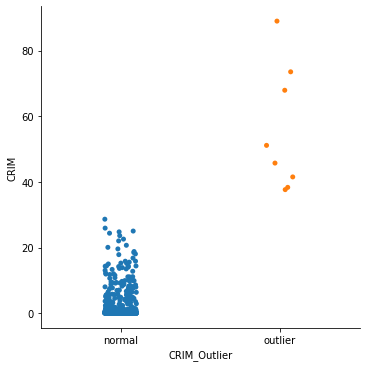

In [3]:
col_x= "CRIM"
col_z = "{}_Z".format(col_x)
col_outlier = "{}_Outlier".format(col_x)
df_x = pd.DataFrame(df_xs[col_x])
std = np.std(df_x.values)
mean = np.mean(df_x.values)
print("mean={}, std={}".format(mean, std))

threshold = 3
df_x[col_z] = (df_x - mean) / std
df_x[col_outlier] = np.where(np.abs(df_x[col_z]) <= threshold, 'normal', 'outlier')
print(df_x.head())

sns.catplot(x=col_outlier, y=col_x, data=df_x)

#### Mean & Standard Deviation

그래프를 보면 Z-Score 값은 Mean - 3 * Std ~ Mean + 3 * Std 와 같이 값의 범위로도 구할수 있습니다.

mean=3.613523557312254, std=8.59304135129577, upper=29.392647611199564, lower=-22.16560049657506
     CRIM CRIM_Outlier
0 0.00632       normal
1 0.02731       normal
2 0.02729       normal
3 0.03237       normal
4 0.06905       normal


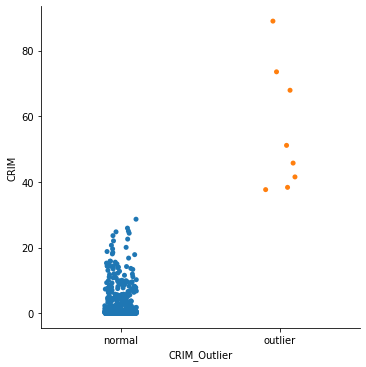

In [5]:
col_x= "CRIM"
col_outlier = "{}_Outlier".format(col_x)
df_x = pd.DataFrame(df_xs[col_x])
std = np.std(df_x.values)
mean = np.mean(df_x.values)

threshold = 3
upper = mean + std * threshold
lower = mean - std * threshold
print("mean={}, std={}, upper={}, lower={}".format(mean, std, upper, lower))

df_x[col_outlier] = np.where((df_x < upper) & (df_x > lower), 'normal', 'outlier')
print(df_x.head())

sns.catplot(x=col_outlier, y=col_x, data=df_x)

#### Modified Z-Score

평군과 표준편차를 이용하는 Z-Score 는 데이터의 크기가 12 이하로 작거나, 데이터의 Skew 가 큰경우 제대로 동작하지 않는 경우가 많습니다. 그래서 평균 대신 중앙값을 이용하는 Modified Z-score 가 주로 사용됩니다.


median=0.25651, median_abs_std=0.22145000000000004
     CRIM   CRIM_Z CRIM_Outlier
0 0.00632 -0.76204       normal
1 0.02731 -0.69811       normal
2 0.02729 -0.69817       normal
3 0.03237 -0.68269       normal
4 0.06905 -0.57097       normal


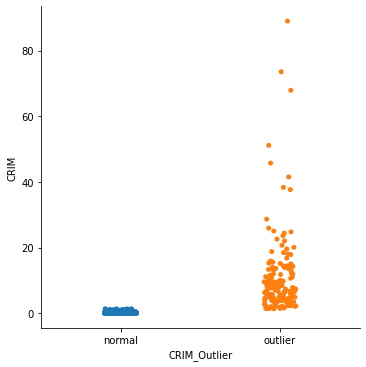

In [6]:
col_x= "CRIM"
col_z = "{}_Z".format(col_x)
col_outlier = "{}_Outlier".format(col_x)
df_x = pd.DataFrame(df_xs[col_x])
median = np.median(df_x.values)
median_abs_std = np.median([np.abs(v - median) for v in df_x.values])
print("median={}, median_abs_std={}".format(median, median_abs_std))

threshold = 3.5
df_x[col_z] = 0.6745 * (df_x - median) / median_abs_std
df_x[col_outlier] = np.where(np.abs(df_x[col_z]) <= threshold, 'normal', 'outlier')
print(df_x.head())

sns.catplot(x=col_outlier, y=col_x, data=df_x)

### Tukey Outlier

Modified Z-score 방식과 같이 Skew 된 데이터에 대해서 강건하도록 Median 값을 이용하는 다른 이상치 탐지 방법입니다.

Boxplot에서는 이상치(Outlier)에 민감하지 않은 분위수를 사용하기 때문에 이를 이용하여 통계적으로 이상치를 잘 검출할 수 있습니다. Boxplot 에서 이상치는 통계적 최소값인 Q1 - 1.5 x IQR 보다 작거나 최대값인 Q3 + 1.5 x IQR 보다 큰 값들을 가르킵니다. 

* IQR(interquartile range) = 3rd Quartile - 1st Quartile
* Upper Bound = 3rd Quartile + (IQR * 1.5)
* Lower Bound = 1st Quartile - (IQR * 1.5)

질적변수에 속하는 명목척도, 서열척도의 경우 평균을 구할 수 없기 때문에 사분위수를 통한 데이터 탐색은 더욱 의미가 큽니다.

q1=0.08204499999999999, q3=3.6770825, lower=-5.31051125, uppwer=9.06963875


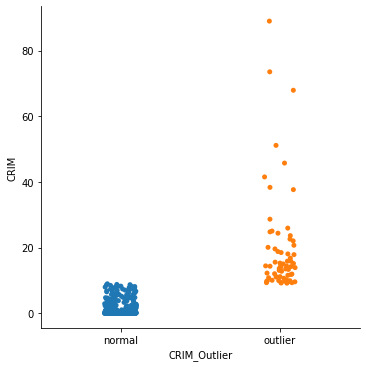

In [7]:
col_x= "CRIM"
col_outlier = "{}_Outlier".format(col_x)
df_x = pd.DataFrame(df_xs[col_x])
q1, q3  = np.percentile(df_x.values, [25, 75])
iqr = q3 - q1
upper = q3 + (iqr * 1.5)
lower = q1 - (iqr * 1.5)

print("q1={}, q3={}, lower={}, uppwer={}".format(q1, q3, lower, upper))
df_x[col_outlier] = np.where((df_x <= upper) & (df_x >= lower), 'normal', 'outlier')

sns.catplot(x=col_outlier, y=col_x, data=df_x)

보통 시각화 라이브러리들에서는 Tukey Outlier 방법을 boxplot 으로 제공하고 있어 한눈에 이상치가 포함된 데이터 인지 아닌지를 판단할수 있도록 시각화해줍니다.

![boxplot](https://cdn-images-1.medium.com/max/800/1*2c21SkzJMf3frPXPAR_gZA.png)

<AxesSubplot:>

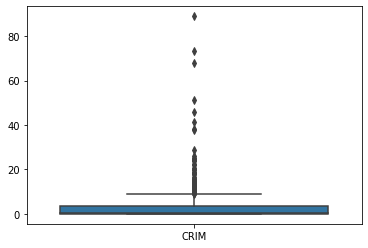

In [8]:
col_x= "CRIM"
df_x = pd.DataFrame(df_xs[col_x])
sns.boxplot(data=df_x)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'CRIM'),
  Text(1, 0, 'ZN'),
  Text(2, 0, 'INDUS'),
  Text(3, 0, 'CHAS'),
  Text(4, 0, 'NOX'),
  Text(5, 0, 'RM'),
  Text(6, 0, 'AGE'),
  Text(7, 0, 'DIS'),
  Text(8, 0, 'RAD'),
  Text(9, 0, 'TAX'),
  Text(10, 0, 'PTRATIO'),
  Text(11, 0, 'B'),
  Text(12, 0, 'LSTAT')])

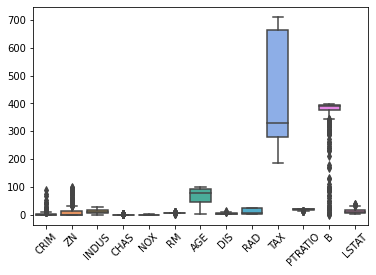

In [9]:
sns.boxplot(data=df_xs)
plt.xticks(rotation=45)

## Multivariate 

2차원 이상의 다변량 데이터에 대해 사용할 수 있는 비지도 학습 방법의 이상치를 탐지하는 방법에 대해서 다룹니다.

데이터는 15% 의 Random uniform noise 를 포함하고 있는 여러 클러스터를 가지는 Scikit-Learn 에서 제공해주는 예제를 기반으로 Toy Dataset 에 대해서 각 알고리즘을 비교해보도록 하겠습니다.

* IsolationForest: 
  * 공간을 분할하여 격자안에 데이터를 고립(Isolation)하는 방법으로 데이터를 분류하기에 이상치는 다수의 분할 없이 큰 격자의 영역을 가지는 점에 착안하여 이상치 정도를 판단합니다.
* LocalOutlierFactor: 
  * 데이터와 주변 데이터들의 거리를 통해서 밀도 기반으로 해당 점의 이상치 정도를 판단합니다, 데이터의 모든 점들에 대한 거리 계산이 필요하기 때문에 계산량이 많은 담점이 있습니다.
  
참조:
* [Comparing anomaly detection algorithms for outlier detection on toy datasets](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py)

Automatically created module for IPython interactive environment


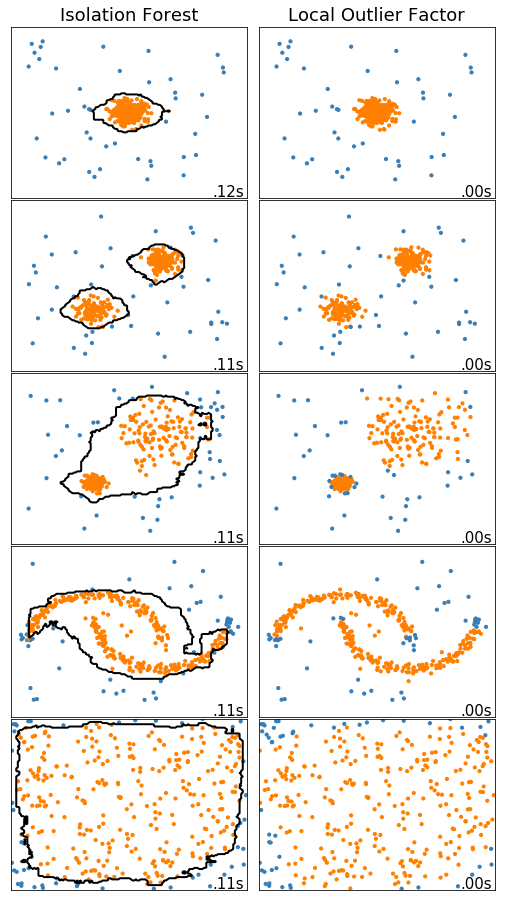

In [2]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Isolation Forest", IsolationForest(behaviour='new',
                                         contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import xgboost as xgb
from sklearn import datasets, model_selection, ensemble, metrics

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
np_train_xs = np.r_[X + 2, X - 2]

# Generate some abnormal novel observations
np_outlier_xs = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
model = ensemble.IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto')
model.fit(np_train_xs)

np_pred_ys = model.predict(np_outlier_xs)

# 1: normail, -1: outlier
print("np_pred_ys: {}".format(np_pred_ys))

np_pred_ys: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
